Antes de mais nada os notebooks aqui mostrado tiveram como base/foram retirados dos seguintes repositórios: 
 > https://github.com/fchollet/deep-learning-with-python-notebooks 
 
 
 > https://github.com/cdfmlr/Deep-Learning-with-Python-Notebooks
 
 Sugiro fortemente que consultem os códigos originais e em caso de dúvida podem me contatar para conversarmos. 

# Aprendizado profundo com Python

## 6.4 Processamento de sequência com convnets

> Sequência de processo com rede neural convolucional

As redes neurais convolucionais podem usar dados com eficácia, extrair recursos locais e modular representações. Por causa desse efeito especial, a CNN não só é boa em lidar com questões de tempo de computador, mas também em lidar de forma eficiente com problemas de sequência.Em alguns problemas de sequência, o efeito e a eficiência da CNN podem até exceder a RNN.

Diferente do Conv2D bidimensional usado para processar imagens, a série temporal é unidimensional, portanto, uma rede neural convolucional unidimensional é usada para o processamento.

### Convolução unidimensional e agrupamento de dados de sequência

Semelhante à convolução bidimensional, a convolução unidimensional extrai segmentos parciais (subsequências) da sequência e, em seguida, executa a mesma transformação em cada segmento. A janela de convolução unidimensional é uma janela unidimensional no eixo do tempo. A natureza desta operação pode garantir que o padrão aprendido em uma posição possa ser reconhecido posteriormente em outras posições (com invariância de tradução no tempo).


A operação de agrupamento unidimensional também é semelhante à operação de agrupamento bidimensional: extrair fragmentos unidimensionais da entrada e emitir o valor máximo (agrupamento máximo) ou valor médio (agrupamento médio). Esta operação também é usada para reduzir o comprimento dos dados (subamostragem).

### Implementar rede neural convolucional unidimensional

No Keras, as redes neurais convolucionais unidimensionais são representadas por camadas Conv1D. O uso é muito semelhante ao Conv2D. Ele recebe entrada com a forma de `(amostras, tempo, recursos)` e retorna a mesma forma. Observe que sua janela está no tempo, que é o segundo eixo da entrada. No Conv2D, nossas janelas são geralmente 3x3, 5x5 e no Conv1D correspondente, geralmente usamos um tamanho de janela de 7 ou 9.

Normalmente, empilhamos a camada Conv1D e a camada MaxPooling1D juntas e, no final de todas as pilhas de agrupamento convolucional, usamos uma operação de agrupamento global ou operação de nivelamento.

Tome o IMDB como exemplo:

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [2]:
import matplotlib.pyplot as plt

def plot_acc_and_loss(history):

    epochs = range(len(history.history['loss']))

    try:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        plt.plot(epochs, acc, 'bo-', label='Training acc')
        plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
    except:
        print('No acc. Skip')
    finally:
        plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

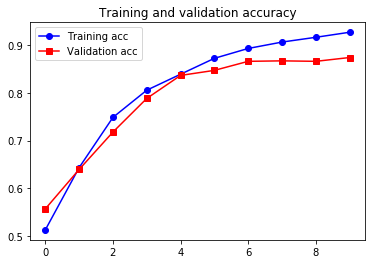

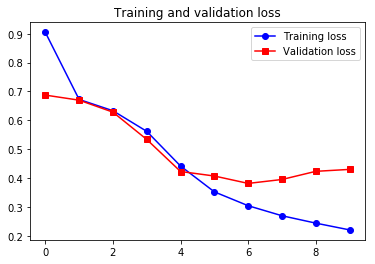

In [3]:
# Treine e avalie uma rede neural convolucional unidimensional simples no IMDB

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))

model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

plot_acc_and_loss(history)

Embora o resultado seja um pouco pior do que RNN, ainda é muito bom e é mais rápido de treinar do que LSTM.

### Combine CNN e RNN para processar sequências longas

A rede neural convolucional unidimensional divide a sequência em fragmentos para aprender e não é sensível à sequência de tempo. Portanto, para aqueles problemas em que a ordem da sequência tem um impacto significativo, o desempenho da CNN é muito pior do que o da RNN. Por exemplo, o problema do conjunto de dados Jena (previsão de temperatura):

In [5]:
# Prepare os dados

import os
import numpy as np

data_dir = ".../jena_climate"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 27s 54ms/step - loss: 0.4144 - val_loss: 0.4308
Epoch 2/20
500/500 [==============================] - 26s 52ms/step - loss: 0.3620 - val_loss: 0.4306
Epoch 3/20
500/500 [==============================] - 23s 45ms/step - loss: 0.3367 - val_loss: 0.4340
Epoch 4/20
500/500 [==============================] - 20s 40ms/step - loss: 0.3220 - val_loss: 0.4492
Epoch 5/20
500/500 [==============================] - 21s 41ms/step - loss: 0.3119 - val_loss: 0.4504
Epoch 6/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3009 - val_loss: 0.4411
Epoch 7/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2940 - val_loss: 0.4398
Epoch 8/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2861 - val_loss: 0.4523
Epoch 9/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2822 - val_loss: 0.4502
Epoch 

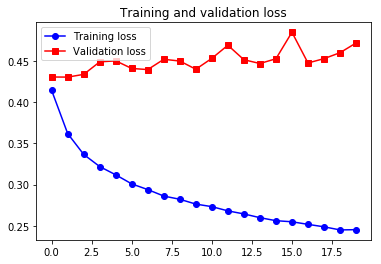

In [6]:
# Treine e avalie uma rede neural convolucional unidimensional simples no conjunto de dados Jena

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_acc_and_loss(history)

Isso não é tão bom quanto o método de senso comum que usamos. As informações visíveis do pedido ainda são muito críticas para esse problema. Para aprender informações sequenciais enquanto mantemos a velocidade e o peso leve das redes neurais convolucionais, podemos combinar CNN e RNN.

Podemos usar Conv1D na frente do RNN. Para sequências muito longas (por exemplo, contendo milhares de etapas de tempo), o uso direto de RNN para processá-lo é muito lento ou mesmo impossível de processar. Adicionar um pouco de Conv1D na frente do RNN pode converter (reduzir a resolução) a sequência de entrada longa em uma sequência mais curta composta de recursos avançados e, em seguida, usar o RNN para processar as informações sensíveis à ordem que podem ser aprendidas.

! [Combine CNN e RNN unidimensional para processar sequências longas] (https://tva1.sinaimg.cn/large/007S8ZIlgy1ghmy56fkp4j30ji0ncgni.jpg)

Usamos esse método para resolver o problema de previsão de temperatura novamente. Como esse método pode aprender uma sequência mais longa, podemos permitir que a rede visualize os dados anteriores (aumente o parâmetro de lookback do gerador de dados) ou que a rede visualize a resolução Séries temporais mais altas (diminua o parâmetro de etapa do gerador):

In [7]:
step = 3  # 30 minutos uma etapa, metade do tempo antes
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 49s 97ms/step - loss: 0.3301 - val_loss: 0.3056
Epoch 2/20
500

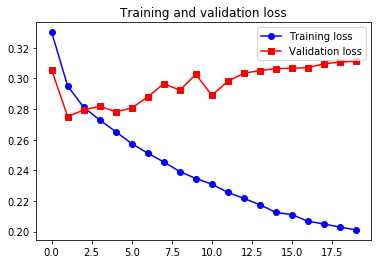

In [8]:
# usar Conv1D + GRU

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_acc_and_loss(history)

Do ponto de vista da perda de verificação, o efeito dessa arquitetura não é tão bom quanto apenas usar GRU regularizado, mas a velocidade é muito mais rápida. Ele analisa o dobro da quantidade de dados, o que pode não ser muito útil neste caso, mas pode ser muito importante para outros conjuntos de dados.

Viu que aqui nós já fomos mais objetivos ne? A ideia é essa mesma, a medida que avançamos as coisas serão mais fluídas. 